Download the data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-09 00:35:12--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.34.23, 99.86.34.116, 99.86.34.8, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.34.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2020-11-09 00:35:12 (51.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Czech.txt', 'data/names/English.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['Baldinotti', 'Guidi', 'Testa', 'Ruzzier', 'Masin']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size + hidden_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined_o = torch.cat((input, hidden), 1)
        combined_hidden_cell = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hidden_cell)
        output = self.i2o(combined_o)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def initCell(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8447, -2.8363, -2.9427, -2.8929, -3.0051, -2.8615, -2.8723, -2.8660,
         -2.9917, -2.8214, -2.9044, -2.8725, -2.8676, -2.7888, -2.8516, -2.9838,
         -2.9059, -2.9487]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 13)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Cao
category = Czech / line = Netsch
category = French / line = Martel
category = German / line = Beltz
category = Irish / line = Eoin
category = Vietnamese / line = Luong
category = Arabic / line = Abboud
category = Vietnamese / line = Tieu
category = Scottish / line = Thomson
category = Greek / line = Panoulias


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
optimizer_rnn = torch.optim.Adam(rnn.parameters())
optimizer_gru = torch.optim.Adam(gru.parameters())
optimizer_lstm = torch.optim.Adam(lstm.parameters())

def train_rnn(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_rnn.step()

    return output, loss.item()

def train_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    # reset gradient
    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_gru.step()

    return output, loss.item()

def train_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    # reset gradient
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_lstm.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses_rnn = []
all_validation_losses_rnn = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset_rnn(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_rnn(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_rnn(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_rnn.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_rnn(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_rnn) == 0 or average_validation_loss < min(all_validation_losses_rnn):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses_rnn.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 20s) 	1.8425 		Slepica / Italian ✗ (Czech)
10000 	12% 	(0m 44s) 	1.5588 		Lachapelle / Italian ✗ (French)
15000 	18% 	(1m 8s) 	1.4634 		Divavin / French ✗ (Russian)
20000 	25% 	(1m 31s) 	1.3563 		Pae / Chinese ✗ (Korean)
25000 	31% 	(1m 55s) 	1.2951 		Rutkowski / Polish ✓
30000 	37% 	(2m 23s) 	1.2435 		Theofilopoulos / Greek ✓
35000 	43% 	(2m 47s) 	1.2851 		Martin / Irish ✗ (Scottish)
40000 	50% 	(3m 10s) 	1.2570 		Jo / Korean ✓
45000 	56% 	(3m 34s) 	1.2114 		Blanxart / English ✗ (Spanish)
50000 	62% 	(3m 58s) 	1.1854 		O'Connor / Irish ✓
55000 	68% 	(4m 21s) 	1.1640 		Duong / Vietnamese ✓
60000 	75% 	(4m 45s) 	1.2410 		Shammas / Arabic ✓
65000 	81% 	(5m 9s) 	1.1106 		Tzalko / Russian ✓
70000 	87% 	(5m 32s) 	1.1210 		Rott / Scottish ✗ (Russian)
75000 	93% 	(5m 55s) 	1.0670 		Mcculloch / English ✓
80000 	100% 	(6m 19s) 	1.0774 		Netsch / Russian ✗ (Czech)


In [ ]:
n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses_gru = []
all_validation_losses_gru = []

# Just return an output given a line
def evaluate_gru(line_tensor):
    hidden = gru.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    return output

def eval_dataset_gru(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_gru(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_gru.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_gru(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_gru) == 0 or average_validation_loss < min(all_validation_losses_gru):
            torch.save(gru, 'char_gru_classification_model.pt')
        all_validation_losses_gru.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 52s) 	1.8068 		Lillis / Greek ✓
10000 	12% 	(1m 50s) 	1.3988 		Morra / Portuguese ✗ (Italian)
15000 	18% 	(2m 49s) 	1.1641 		Ron / Korean ✓
20000 	25% 	(3m 47s) 	0.9507 		Itami / Japanese ✓
25000 	31% 	(4m 46s) 	0.8234 		Pecora / Italian ✓
30000 	37% 	(5m 43s) 	0.6878 		Gorski / Polish ✓
35000 	43% 	(6m 42s) 	0.6740 		Rick / Irish ✗ (English)
40000 	50% 	(7m 40s) 	0.5957 		Gwozdek / Polish ✓
45000 	56% 	(8m 39s) 	0.4754 		Min / Chinese ✓
50000 	62% 	(9m 37s) 	0.4962 		Mackenzie / Scottish ✓
55000 	68% 	(10m 36s) 	0.4136 		Zheimo / Italian ✗ (Russian)
60000 	75% 	(11m 35s) 	0.4323 		Rooijakker / Dutch ✓
65000 	81% 	(12m 34s) 	0.3718 		Deforest / French ✓
70000 	87% 	(13m 32s) 	0.3435 		Falk / Czech ✗ (German)
75000 	93% 	(14m 31s) 	0.3778 		Chlebek / Polish ✓
80000 	100% 	(15m 30s) 	0.3651 		O'Brien / Irish ✓


In [ ]:
n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses_lstm = []
all_validation_losses_lstm = []

# Just return an output given a line
def evaluate_lstm(line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()
    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
    return output

def eval_dataset_lstm(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_lstm(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_lstm.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_lstm(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_lstm) == 0 or average_validation_loss < min(all_validation_losses_lstm):
            torch.save(lstm, 'char_lstm_classification_model.pt')
        all_validation_losses_lstm.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(1m 4s) 	1.9140 		Lozinsky / Polish ✗ (Russian)
10000 	12% 	(2m 14s) 	1.4139 		Kobayashi / Japanese ✓
15000 	18% 	(3m 24s) 	1.1872 		Kamo / Japanese ✓
20000 	25% 	(4m 35s) 	0.9300 		Strobel / German ✓
25000 	31% 	(5m 45s) 	0.7707 		Kitabatake / Japanese ✓
30000 	37% 	(6m 56s) 	0.7198 		Havroshin / Russian ✓
35000 	43% 	(8m 7s) 	0.6875 		Paloumbas / Greek ✓
40000 	50% 	(9m 19s) 	0.5791 		Daal / Dutch ✓
45000 	56% 	(10m 30s) 	0.6363 		Soares / Portuguese ✓
50000 	62% 	(11m 41s) 	0.5009 		Shui / Chinese ✓
55000 	68% 	(12m 51s) 	0.4726 		Qureshi / Arabic ✓
60000 	75% 	(14m 2s) 	0.4919 		Paquet / French ✓
65000 	81% 	(15m 12s) 	0.4733 		Carver / German ✓
70000 	87% 	(16m 23s) 	0.4667 		Musaev / Russian ✓
75000 	93% 	(17m 33s) 	0.4413 		Almondinov / Russian ✓
80000 	100% 	(18m 43s) 	0.5270 		Sai / Vietnamese ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




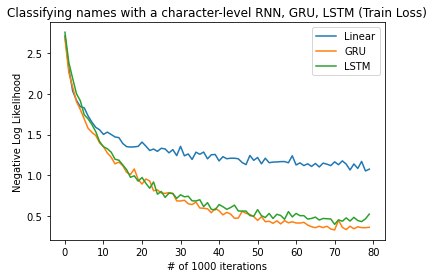

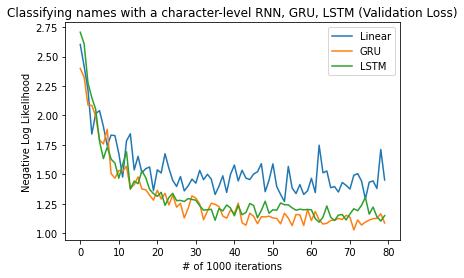

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_rnn)
plt.plot(all_train_losses_gru)
plt.plot(all_train_losses_lstm)
plt.title('Classifying names with a character-level RNN, GRU, LSTM (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'GRU', 'LSTM'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses_rnn)
plt.plot(all_validation_losses_gru)
plt.plot(all_validation_losses_lstm)
plt.title('Classifying names with a character-level RNN, GRU, LSTM (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'GRU', 'LSTM'], loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss: 1.2490515043162695


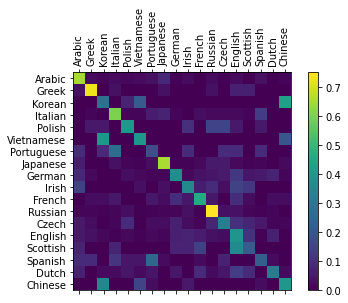

In [ ]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset_rnn(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss: 1.0128323924577225


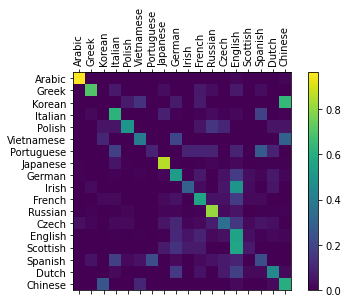

In [ ]:
# evaluate on test set and display confusion matrix
gru = torch.load('char_gru_classification_model.pt')
average_test_loss, confusion = eval_dataset_gru(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Average test loss: 1.078898586538862


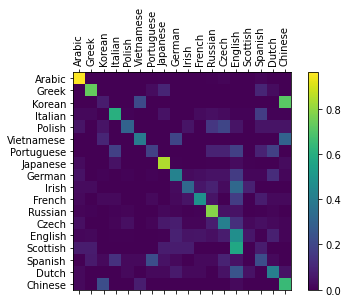

In [ ]:
# evaluate on test set and display confusion matrix
lstm = torch.load('char_lstm_classification_model.pt')
average_test_loss, confusion = eval_dataset_lstm(test_data)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# **Explanation:**
### GRU and LSTM are more expressive than linear. One difficulty with an RNN is that it can be very difficult to train it to maintain information in its hidden state for a long time. RNN has the problem of vanishing/exploding gradient because of 􏱋􏰸􏰴􏰼􏱀􏰶􏰻􏱀􏰸􏱉􏰸􏰮􏰭􏰻􏰬backpropagation through time(BPTT). While LSTM combats this state decay. LSTM mitigates gradient vanishing and facilitates long term memory. And GRU perform similar to LSTM and is still better than RNN. 

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.


